# Vanilla LSTM Evaluation and Profiling

This notebook evaluates a fully trained, frozen deterministic (vanilla) LSTM for multi-horizon load forecasting.
It is a reproducible baseline for later Bayesian comparisons and does not retrain or tune the model.

**Constraints**
- No model retraining or hyperparameter tuning
- No uncertainty modeling
- Use `model.eval()` and disable gradients for inference
- Assume model artifacts, scalers, and config are already saved and loadable


## 1. Setup and Imports
All analysis is performed in evaluation mode with gradients disabled for inference.


In [1]:
from __future__ import annotations

import json
import platform
import random
import time
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import shap

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid")


c:\Users\lhaus\Documents\FH\probabilistic-load-forecast-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration and Artifact Paths
Adjust paths if your artifact layout differs. The defaults align with the data preparation notebook.


In [ ]:
DATA_DIR = Path("../../data/processed")
EXPERIMENT_NAME = "fs_06_load_calendar_future_weather"
OUTPUT_DIR = DATA_DIR / "ml_data" / EXPERIMENT_NAME

MODEL_DIR = OUTPUT_DIR / "models"
SCALERS_DIR = OUTPUT_DIR / "scalers"

MODEL_FULL_PATH = MODEL_DIR / "final_model_v1_full.pt"
MODEL_STATE_PATH = MODEL_DIR / "final_model_v1_state.pt"
MODEL_CONFIG_PATH = MODEL_DIR / "model_config.json"
META_PATH = OUTPUT_DIR / "meta.json"

X_TEST_PATH = OUTPUT_DIR / "X_test.npy"
Y_TEST_PATH = OUTPUT_DIR / "y_test.npy"
X_SCALER_PATH = SCALERS_DIR / "X_scaler.pkl"
Y_SCALER_PATH = SCALERS_DIR / "y_scaler.pkl"

RAW_DATA_PATH = DATA_DIR / "data_combined.parquet"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 12345

print("Device:", DEVICE)
print("Output directory:", OUTPUT_DIR)


Device: cuda
Output directory: ..\..\data\processed\ml_data\fs_06_load_calendar_future_weather


## 3. Model Definition and Artifact Loading
The model is treated as a frozen predictor. We load the saved weights and scalers and verify dimensions.


In [3]:
class VanillaLSTM(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float, horizon: int):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.fc = torch.nn.Linear(hidden_size, horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        return self.fc(h)


In [4]:
import pickle

with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

with open(X_SCALER_PATH, "rb") as f:
    x_scaler = pickle.load(f)

with open(Y_SCALER_PATH, "rb") as f:
    y_scaler = pickle.load(f)

X_test = np.load(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)

window_size = int(meta["window_size"])
horizon = int(meta["forecast_horizon"])
feature_names = list(meta["feature_names"])

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("window_size:", window_size, "horizon:", horizon)
print("n_features (meta):", meta["n_features"])


X_test shape: (39810, 672, 11)
y_test shape: (39810, 96)
window_size: 672 horizon: 96
n_features (meta): 11


In [5]:
def load_model() -> torch.nn.Module:
    # if MODEL_FULL_PATH.exists():
    #     model = torch.load(MODEL_FULL_PATH, map_location=DEVICE, weights_only=False)
    #     return model
    # raise FileNotFoundError("No model file found at expected paths.")

    if not MODEL_STATE_PATH.exists():
        raise FileNotFoundError("No model file found at expected paths.")

    if not MODEL_CONFIG_PATH.exists():
        raise FileNotFoundError("State dict found but model_config.json is missing.")

    with open(MODEL_CONFIG_PATH, "r", encoding="utf-8") as f:
        cfg = json.load(f)

    model = VanillaLSTM(
        input_size=meta["n_features"],
        hidden_size=cfg["hidden_size"],
        num_layers=cfg["num_layers"],
        dropout=cfg["dropout"],
        horizon=meta["forecast_horizon"],
    )
    state = torch.load(MODEL_STATE_PATH, map_location=DEVICE)
    model.load_state_dict(state)
    return model

model = load_model().to(DEVICE)
model.eval()

assert X_test.shape[2] == meta["n_features"], "Feature dimension mismatch."

with torch.no_grad():
    y_pred_shape_check = model(torch.from_numpy(X_test[:2]).float().to(DEVICE)).shape

print("Model output shape (batch, horizon):", y_pred_shape_check)
assert y_pred_shape_check[1] == horizon, "Output horizon mismatch."


Model output shape (batch, horizon): torch.Size([2, 96])


## 4. Output Semantics and Sanity Checks
We verify the alignment of the forecast horizons. The convention is:
- `y_hat[:, h]` predicts load at time `t + h + 1`
- Horizon index `h=0` corresponds to one step ahead

We also confirm that outputs are inverse-scaled and expressed in MW and document the step size.


In [6]:
def create_sequences_indices(n_samples: int, window: int, horizon: int) -> np.ndarray:
    indices = []
    for i in range(n_samples - window - horizon + 1):
        indices.append(np.arange(i + window, i + window + horizon))
    return np.array(indices)

df_raw = pd.read_parquet(RAW_DATA_PATH)
df_raw = df_raw.sort_index()

y = df_raw["actual_load_mw"].to_frame()
X = df_raw[meta["feature_names"]]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.33, shuffle=False)
X_val, X_test_df, y_val, y_test_df = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

test_index = y_test_df.index
test_index_np = test_index.to_numpy()
target_indices = create_sequences_indices(len(test_index_np), window_size, horizon)
target_timestamps = test_index_np[target_indices] # leverages numpy advanced indexing



In [7]:
test_dataset = TensorDataset(
    torch.from_numpy(X_test).float()
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1024
)

preds = []

model.eval()
with torch.no_grad():
    for xb, in test_loader:
        xb = xb.to(DEVICE)
        y_pred_scaled = model(xb).cpu()

        preds.append(y_pred_scaled)

torch.cuda.empty_cache()

y_pred_scaled = y_scaler.inverse_transform(np.vstack(preds))
y_true_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, horizon)

Next a the sample is plotted visually for an quick analysis of the model output.

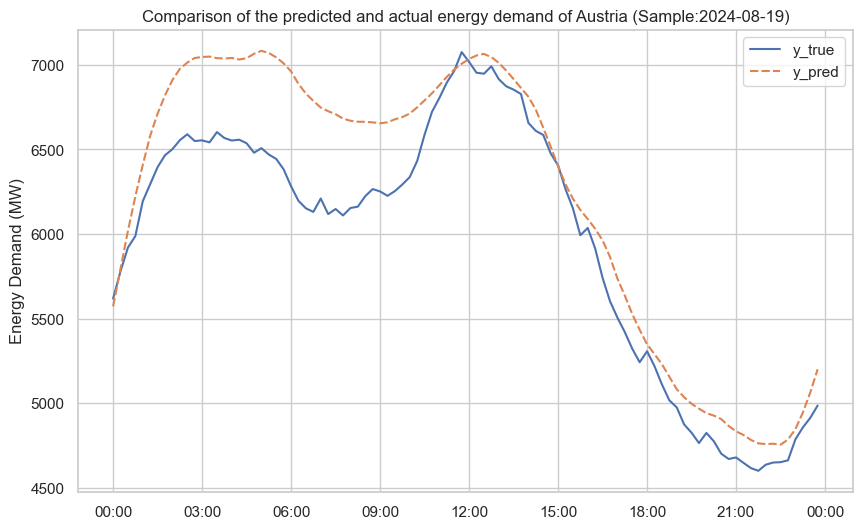

In [8]:
sample_idx = 21

sample_pred_df = pd.DataFrame(
    data={
        "y_true": y_true_scaled[sample_idx],
        "y_pred": y_pred_scaled[sample_idx],
    },
    index=target_timestamps[sample_idx]
)

# sample_pred_df.head()
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(
    data=sample_pred_df,
    ax=ax
)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_title("Comparison of the predicted and actual energy demand of Austria (Sample:2024-08-19)")
ax.set_ylabel("Energy Demand (MW)");

The plotted values reveal the prediction matches the overall pattern of the load curve quite well. The curves match up during the end of the end of the forecast window, while there is some clear missalignment in the beginning. While this single plot cannto reveal patterns about possible model missfit it quite shows that the model is at least somewhat capable of fitting the data at hand. 

## 5. Deterministic Point Forecast Accuracy
Metrics are reported overall and per horizon. These curves form the deterministic baseline.


In [9]:
overall_mae = mean_absolute_error(y_true_scaled, y_pred_scaled)
overall_rmse = root_mean_squared_error(y_true_scaled, y_pred_scaled)

per_horizon = []
for h in range(horizon):
    per_horizon.append({
        "horizon": h + 1,
        "mae": mean_absolute_error(y_true_scaled[:, h], y_pred_scaled[:, h]),
        "rmse": root_mean_squared_error(y_true_scaled[:, h], y_pred_scaled[:, h]),
    })

metrics_df = pd.DataFrame(per_horizon)
metrics_df.head()

print(f"Overall MAE (MW): {overall_mae:.3f}")
print(f"Overall RMSE (MW): {overall_rmse:.3f}")


Overall MAE (MW): 246.794
Overall RMSE (MW): 377.057


A quick sanity check; The loaded model is in the expected range of the error as verified in the feature evaluation step, which was done using temporal cross validation: 
<br><br>
![Expected error ranges](../../data/images/fs_06.error_sanity_check_comparision.png)


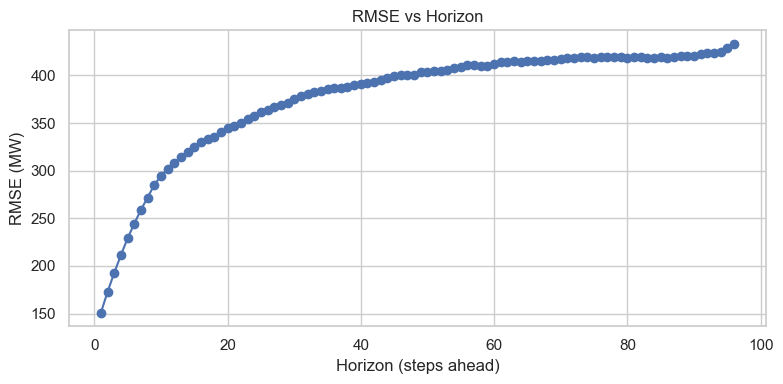

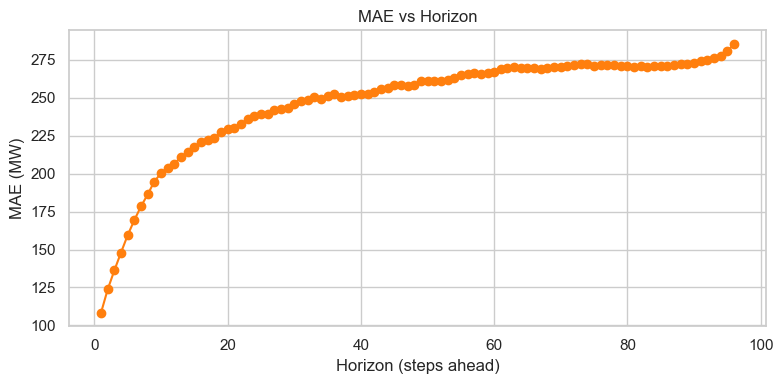

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(metrics_df["horizon"], metrics_df["rmse"], marker="o")
plt.xlabel("Horizon (steps ahead)")
plt.ylabel("RMSE (MW)")
plt.title("RMSE vs Horizon")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(metrics_df["horizon"], metrics_df["mae"], marker="o", color="tab:orange")
plt.xlabel("Horizon (steps ahead)")
plt.ylabel("MAE (MW)")
plt.title("MAE vs Horizon")
plt.tight_layout()
plt.show()


Plotting both error values over the forecast horizons, shows that the error get worse during the end of the horizons which is expected for this type of modelling.

## 6. Temporal Error Structure
Next, error patterns by hour of day and by weekday/weekend (and holiday if available) are analyzed.
Monthly RMSE is reported as an optional seasonal diagnostic.


Text(0.5, 1.0, 'Hour-of-day RMSE')

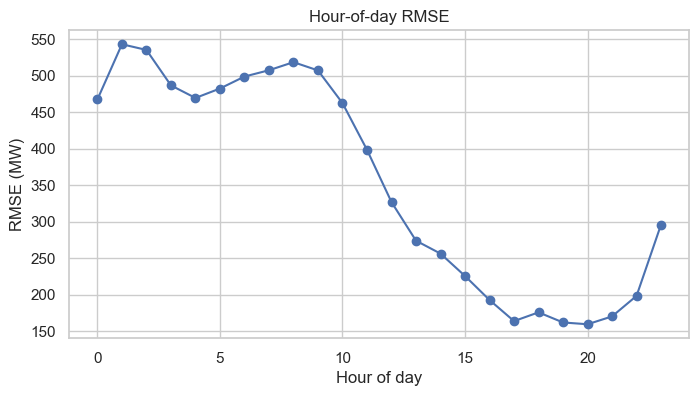

In [ ]:
errors = y_true_scaled - y_pred_scaled

time_rows = []
for i in range(errors.shape[0]):
    for h in range(horizon):
        ts = target_timestamps[i, h]
        time_rows.append({
            "timestamp": ts,
            "horizon": h + 1,
            "error": errors[i, h],
        })

time_df = pd.DataFrame(time_rows)
time_df["hour"] = pd.to_datetime(time_df["timestamp"]).dt.hour
time_df["weekday"] = pd.to_datetime(time_df["timestamp"]).dt.weekday
time_df["is_weekend"] = time_df["weekday"] >= 5

if "is_holiday" in df_raw.columns:
    holiday_map = df_raw["is_holiday"]
    time_df["is_holiday"] = time_df["timestamp"].map(holiday_map).fillna(0).astype(int)
else:
    time_df["is_holiday"] = np.nan

hour_rmse = (
    time_df.groupby("hour")["error"]
    .apply(lambda x: float(np.sqrt(np.mean(x**2))))
    .reset_index(name="rmse")
)

plt.figure(figsize=(8, 4))
plt.plot(hour_rmse["hour"], hour_rmse["rmse"], marker="o")
plt.xlabel("Hour of day")
plt.ylabel("RMSE (MW)")
plt.title("Hour-of-day RMSE");

Text(0.5, 1.0, 'RMSE heatmap: hour x horizon (MW)')

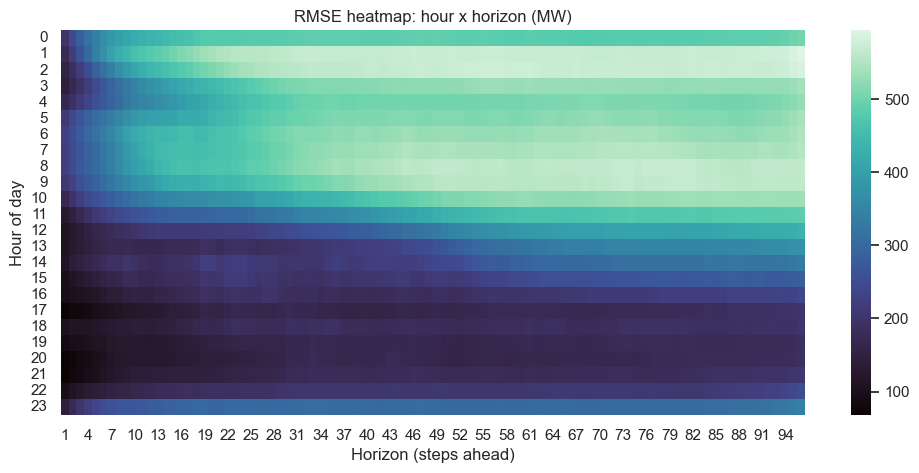

In [ ]:
pivot = (
    time_df.pivot_table(
        index="hour",
        columns="horizon",
        values="error",
        aggfunc=lambda x: float(np.sqrt(np.mean(x**2))),
    )
)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot, cmap="mako")
plt.xlabel("Horizon (steps ahead)")
plt.ylabel("Hour of day")
plt.title("RMSE heatmap: hour x horizon (MW)");

This lighter colors indicate, while the error seems to be lower during the evening hours it is higher during the morning hours (1-10). Further reasoning might be done in the future to evaluate if this is correlated to the energy bimodal demand pattern that was already identified in the initial eda. Perhaps this could lead to a new feature that could help the model better capture this pattern.

Next, the focus is shifted to plotting the models performance during the different months.

In [13]:
weekday_rmse = (
    time_df.groupby("is_weekend")["error"]
    .apply(lambda x: float(np.sqrt(np.mean(x**2))))
    .reset_index(name="rmse")
)
weekday_rmse

if time_df["is_holiday"].notna().any():
    holiday_rmse = (
        time_df.groupby("is_holiday")["error"]
        .apply(lambda x: float(np.sqrt(np.mean(x**2))))
        .reset_index(name="rmse")
    )
    holiday_rmse


Text(0.5, 1.0, 'Monthly RMSE')

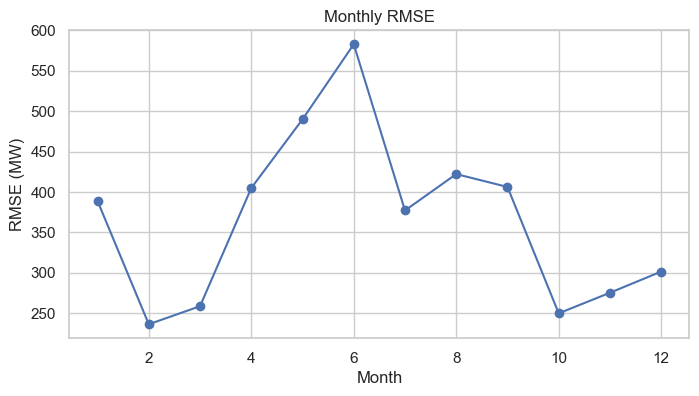

In [ ]:
time_df["month"] = pd.to_datetime(time_df["timestamp"]).dt.month
month_rmse = (
    time_df.groupby("month")["error"]
    .apply(lambda x: float(np.sqrt(np.mean(x**2))))
    .reset_index(name="rmse")
)

plt.figure(figsize=(8, 4))
plt.plot(month_rmse["month"], month_rmse["rmse"], marker="o")
plt.xlabel("Month")
plt.ylabel("RMSE (MW)")
plt.title("Monthly RMSE");

The plot reveals that there is an error rising after April up to June, which should be evaluated further. Perhaps this is linked as to the regime shift of less demand while the cooling demand emerges intermittently. The former learned feature-relationships could become weakly identifiable during this period.

Another experiment might focus on training the model on a new period of the year, which was October for this model, and identify if this new model has a reduced version of this affect. A hypothesis is that this might indicate that initial training samples heavily influence the patterns that the model can caputre.

Finally, residuals are analyzed across demand quantiles to identify the load ranges in which forecast errors are most pronounced.

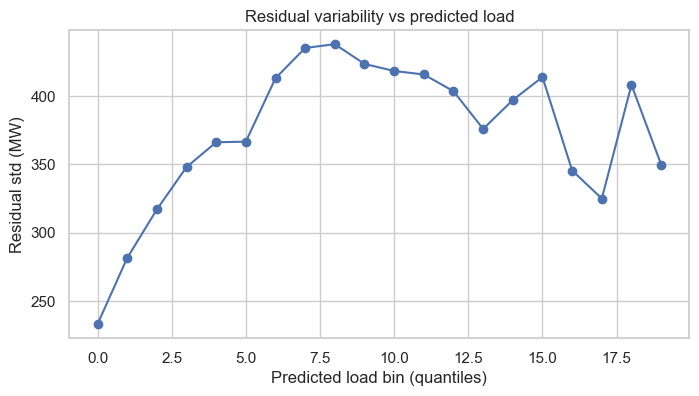

In [21]:
pred_flat = y_pred_scaled.reshape(-1)
residual_flat = errors.reshape(-1)

bins = pd.qcut(pred_flat, q=20, duplicates="drop")
binned = (
    pd.DataFrame({"pred": pred_flat, "residual": residual_flat})
    .assign(bin=bins)
    .groupby("bin", observed=False)["residual"]
    .agg(["mean", "std"])
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.plot(range(len(binned)), binned["std"], marker="o")
plt.xlabel("Predicted load bin (quantiles)")
plt.ylabel("Residual std (MW)")
plt.title("Residual variability vs predicted load");

Residual variability depends strongly on the predicted load level. Errors are lowest at low demand, increase toward the mid-range where they peak, and decrease again before rising at the highest load quantiles. This indicates robust performance under stable low-demand conditions, increased uncertainty during transitional demand regimes, and additional difficulty in modeling extreme load events.

## 8. Deterministic SHAP Interpretability
Explain a single output horizon (default: h=24). SHAP uses gradients for attribution.

Sample sizes are set to balance runtime and stability; adjust if needed.

Limitations: SHAP here is deterministic and does not capture predictive uncertainty.


In [26]:
class HorizonWrapper(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, horizon: int):
        super().__init__()
        self.model = model
        self.h = horizon - 1  # zero-based

    def forward(self, x):
        out = self.model(x)[:, self.h]   # (N,)
        return out.unsqueeze(1)          # (N, 1)

C:\Users\lhaus\AppData\Local\Temp\ipykernel_18848\624120717.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


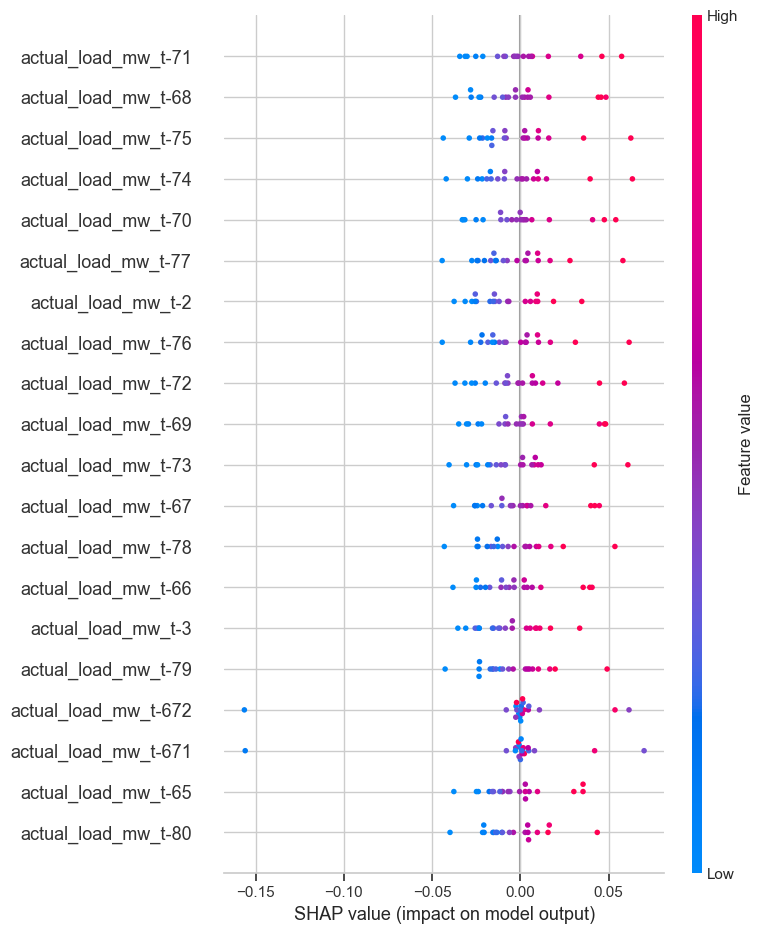

C:\Users\lhaus\AppData\Local\Temp\ipykernel_18848\624120717.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


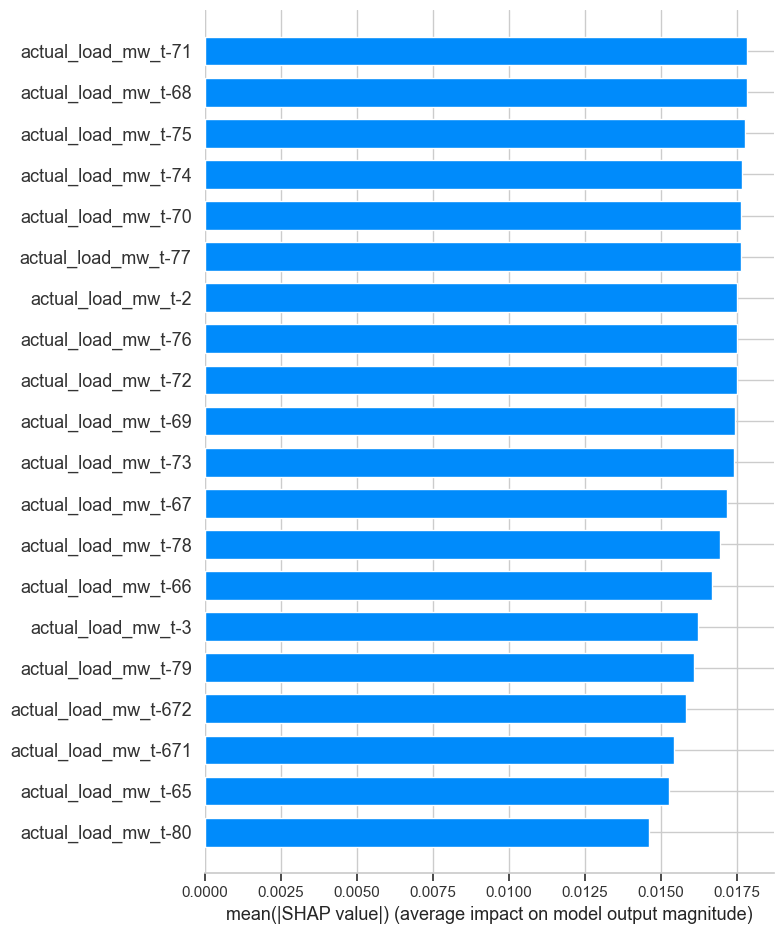

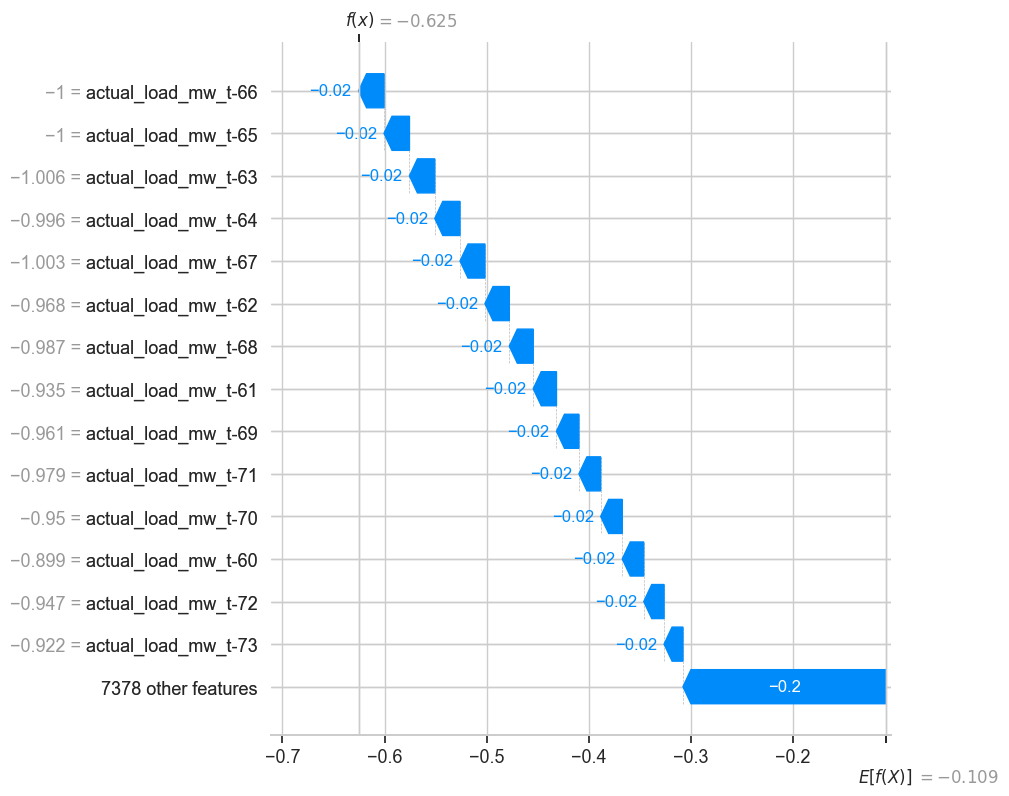

In [28]:
SHAP_HORIZON = 24
BACKGROUND_SAMPLES = 10#100
EXPLAIN_SAMPLES = 20#200

torch.backends.cudnn.enabled = False # must be turned off because limitations by cuDNN 
wrapped_model = HorizonWrapper(model, SHAP_HORIZON).to(DEVICE)

def make_feature_names(base_features, window):
    names = []
    for t in range(window):
        lag = window - t
        for feat in base_features:
            names.append(f"{feat}_t-{lag}")
    return names

feature_names_full = make_feature_names(feature_names, window_size)

rng = np.random.default_rng(SEED)
idx = rng.choice(len(X_test), size=min(EXPLAIN_SAMPLES, len(X_test)), replace=False)
bg_idx = rng.choice(len(X_test), size=min(BACKGROUND_SAMPLES, len(X_test)), replace=False)

X_explain = torch.from_numpy(X_test[idx]).float().to(DEVICE)
X_background = torch.from_numpy(X_test[bg_idx]).float().to(DEVICE)

with torch.enable_grad():
    explainer = shap.GradientExplainer(wrapped_model, X_background)
    shap_values = explainer.shap_values(X_explain)

shap_values = np.array(shap_values)
baseline_pred = model(X_background).mean().item()

X_explain_np = X_test[idx].reshape(len(idx), -1)
shap_flat = shap_values.reshape(len(idx), -1)

shap.summary_plot(
    shap_flat,
    X_explain_np,
    feature_names=feature_names_full,
    max_display=20,
)

shap.summary_plot(
    shap_flat,
    X_explain_np,
    feature_names=feature_names_full,
    plot_type="bar",
    max_display=20,
)

sample_id = 0
shap.waterfall_plot(
    shap.Explanation(
        values=shap_flat[sample_id],
        base_values=baseline_pred,
        data=X_explain_np[sample_id],
        feature_names=feature_names_full,
    ),
    max_display=15,
)


## 9. SHAP Test
Shuffle a key feature and verify that its importance collapses.


In [ ]:
key_feature = "actual_load_mw"

if key_feature in feature_names:
    feat_idx = feature_names.index(key_feature)
    most_recent_t = window_size - 1
    flat_index = most_recent_t * len(feature_names) + feat_idx

    X_explain_shuffled = X_test[idx].copy().reshape(len(idx), -1)
    rng.shuffle(X_explain_shuffled[:, flat_index])

    X_explain_shuffled_3d = X_explain_shuffled.reshape(len(idx), window_size, len(feature_names))

    with torch.enable_grad():
        shap_values_shuffled = explainer.shap_values(
            torch.from_numpy(X_explain_shuffled_3d).float().to(DEVICE)
        )

    shap_values_shuffled = np.array(shap_values_shuffled).reshape(len(idx), -1)

    baseline_importance = np.mean(np.abs(shap_flat), axis=0)
    shuffled_importance = np.mean(np.abs(shap_values_shuffled), axis=0)

    compare = pd.DataFrame({
        "feature": feature_names_full,
        "baseline": baseline_importance,
        "shuffled": shuffled_importance,
    }).sort_values("baseline", ascending=False)

    compare_head = compare.head(20)

    plt.figure(figsize=(10, 4))
    x = np.arange(len(compare_head))
    plt.bar(x - 0.2, compare_head["baseline"], width=0.4, label="baseline")
    plt.bar(x + 0.2, compare_head["shuffled"], width=0.4, label="shuffled")
    plt.xticks(x, compare_head["feature"], rotation=90)
    plt.ylabel("mean |SHAP|")
    plt.title("SHAP importance before vs after feature shuffle")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Key feature '{key_feature}' not found in feature list.")
